# PoC Crimea 2014

## Obtención de datos

In [58]:
import pandas as pd
import yfinance as yf
from datetime import datetime

# --- 1. Definición de Parámetros ---

START_DATE = "2012-02-27"
END_DATE = "2014-02-27"  

# Definimos el tiempo cero para usarlo más adelante en los gráficos
T_ZERO = pd.to_datetime("2014-02-27")

# Creamos un diccionario con todos los tickers que queremos de Yahoo Finance
TICKERS = {
    "rub": "RUB=X",
    "brent": "BZ=F",
    "vix": "^VIX",
    "gold": "GC=F",
    "dax": "^GDAXI",
    "stoxx": "^STOXX50E"
}

# --- 2. Carga del Índice MOEX  ---

try:
    moex_df = pd.read_csv("data/MOEX.csv")
    print("✅ Índice MOEX cargado correctamente.")
    # print(moex_df.head()) # Descomentar para inspeccionar
except FileNotFoundError:
    print("❌ ERROR: No se encontró el archivo 'data/MOEX.csv'. Asegúrate de que el archivo existe en esa carpeta.")

# --- 3. Descarga de Datos desde yfinance ---

# Usamos un diccionario para almacenar todos los dataframes descargados
dataframes = {}

for name, ticker in TICKERS.items():
    print(f"Descargando datos para {name} ({ticker})...")
    df = yf.download(ticker, start=START_DATE, end=END_DATE)
    if not df.empty:
        dataframes[name] = df
        print(f"✅ Datos para {name} descargados. {len(df)} filas.")
    else:
        print(f"⚠️ No se encontraron datos para {name} ({ticker}).")

# Acceso a un dataframe (ejemplo: Rublo)
print("\n--- Inspección Rápida de un DataFrame Descargado (Rublo) ---")
if 'rub' in dataframes:
    rub_df = dataframes['rub']
    print(rub_df.head())
    date_close = rub_df[["Close"]]
    print(date_close.head())

/var/folders/3m/jcdgmg5j2c169r0054176rm40000gn/T/ipykernel_11824/2011004496.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/var/folders/3m/jcdgmg5j2c169r0054176rm40000gn/T/ipykernel_11824/2011004496.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/var/folders/3m/jcdgmg5j2c169r0054176rm40000gn/T/ipykernel_11824/2011004496.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/var/folders/3m/jcdgmg5j2c169r0054176rm40000gn/T/ipykernel_11824/2011004496.py:39: FutureWarning: YF.download() has changed argument 

✅ Índice MOEX cargado correctamente.
Descargando datos para rub (RUB=X)...
✅ Datos para rub descargados. 522 filas.
Descargando datos para brent (BZ=F)...
✅ Datos para brent descargados. 485 filas.
Descargando datos para vix (^VIX)...
✅ Datos para vix descargados. 503 filas.
Descargando datos para gold (GC=F)...
✅ Datos para gold descargados. 503 filas.
Descargando datos para dax (^GDAXI)...
✅ Datos para dax descargados. 505 filas.
Descargando datos para stoxx (^STOXX50E)...
✅ Datos para stoxx descargados. 497 filas.

--- Inspección Rápida de un DataFrame Descargado (Rublo) ---
Price           Close       High        Low       Open Volume
Ticker          RUB=X      RUB=X      RUB=X      RUB=X  RUB=X
Date                                                         
2012-02-27  29.140200  29.201000  28.941999  29.140200      0
2012-02-28  28.998199  29.117001  28.831200  28.994200      0
2012-02-29  28.998199  29.228701  28.903200  28.998199      0
2012-03-01  29.188200  29.379000  29.002001

## Limpieza y unificación de los datos

In [59]:
from pandas import DataFrame

print("Iniciando Limpieza y Unificación de Datos...")

# --- 1. Definición de Nombres de Columna ---
# Creamos un diccionario para mapear nuestros nombres cortos a los nombres finales
COLUMN_NAMES = {
    "moex": "moex",
    "rub": "rub",
    "brent": "brent",
    "vix": "vix",
    "gold": "gold",
    "dax": "dax",
    "stoxx": "stoxx"
}


# --- 2. Preparar la lista para guardar los DataFrames limpios ---
cleaned_dfs = []

# --- 3. Limpiar el DataFrame del MOEX ---
moex_df['Price'] = moex_df['Price'].str.replace(',', '', regex=False)
moex_df['Price'] = moex_df['Price'].astype(float)
moex_df['Date'] = pd.to_datetime(moex_df['Date'])
moex_df = moex_df.set_index('Date')
moex_clean = moex_df[['Price']].rename(columns={'Price': COLUMN_NAMES['moex']})
cleaned_dfs.append(moex_clean)
print(f"✅ DataFrame de '{COLUMN_NAMES['moex']}' limpiado y estandarizado.")

# --- 4. Limpiar todos los DataFrames de yfinance en un bucle ---
for name, df in dataframes.items():
    df.index = pd.to_datetime(df.index)
    final_col_name = COLUMN_NAMES[name] 
    close_values = df['Close'].values
    cleaned_df = pd.DataFrame(data=close_values, index=df.index, columns=[final_col_name])
    cleaned_dfs.append(cleaned_df)
    print(f"✅ DataFrame de '{final_col_name}' limpiado y estandarizado.")

# --- 5. Unir todos los DataFrames limpios en una única tabla maestra ---
master_df = pd.concat(cleaned_dfs, axis=1)

# --- 6. Manejar los valores nulos (NaN) ---
master_df = master_df.fillna(method='ffill')
master_df = master_df.fillna(method='bfill')

# --- 7. Inspección Final ---
print("\n--- Proceso de Unificación Completado ---")
print("Dimensiones de la tabla maestra:", master_df.shape)
print("\nPrimeras 5 filas de la tabla maestra con nombres finales:")
print(master_df.head())

Iniciando Limpieza y Unificación de Datos...
✅ DataFrame de 'moex' limpiado y estandarizado.
✅ DataFrame de 'rub' limpiado y estandarizado.
✅ DataFrame de 'brent' limpiado y estandarizado.
✅ DataFrame de 'vix' limpiado y estandarizado.
✅ DataFrame de 'gold' limpiado y estandarizado.
✅ DataFrame de 'dax' limpiado y estandarizado.
✅ DataFrame de 'stoxx' limpiado y estandarizado.

--- Proceso de Unificación Completado ---
Dimensiones de la tabla maestra: (523, 7)

Primeras 5 filas de la tabla maestra con nombres finales:
               moex        rub       brent        vix         gold  \
Date                                                                 
2012-02-27  1592.66  29.140200  124.169998  18.190001  1773.599976   
2012-02-28  1574.10  28.998199  121.550003  17.959999  1787.000000   
2012-02-29  1597.67  28.998199  122.660004  18.430000  1709.900024   
2012-03-01  1595.78  29.188200  126.199997  17.260000  1721.099976   
2012-03-02  1608.08  29.120199  123.650002  17.290001  1

/var/folders/3m/jcdgmg5j2c169r0054176rm40000gn/T/ipykernel_11824/2689169056.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df = master_df.fillna(method='ffill')
/var/folders/3m/jcdgmg5j2c169r0054176rm40000gn/T/ipykernel_11824/2689169056.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df = master_df.fillna(method='bfill')


## Gráficos

### Índice VIX

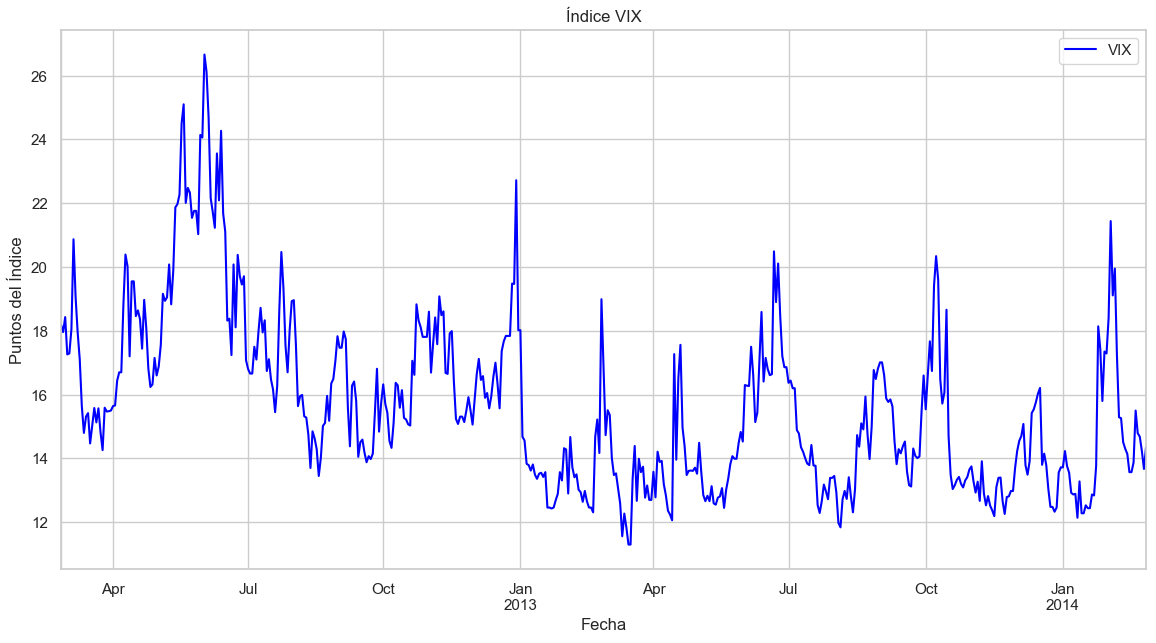

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['vix'].plot(label='VIX', color='blue')

# Añadir títulos
plt.title('Índice VIX')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()



### Índice RUB/USD

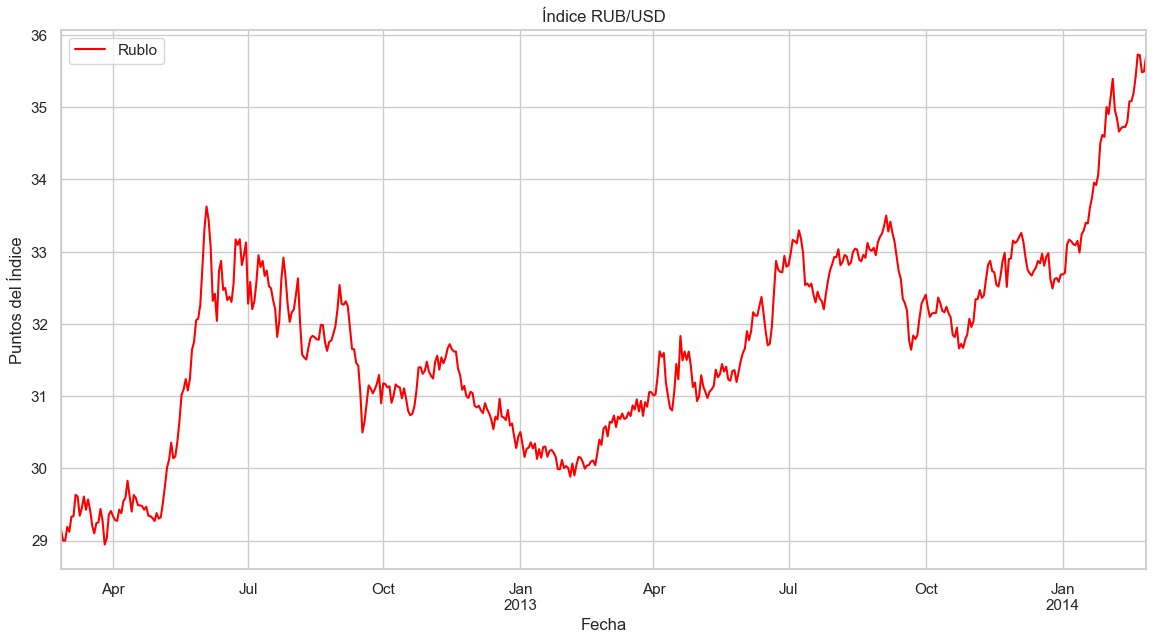

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['rub'].plot(label='Rublo', color='red')

# Añadir títulos
plt.title('Índice RUB/USD')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Índice Brent

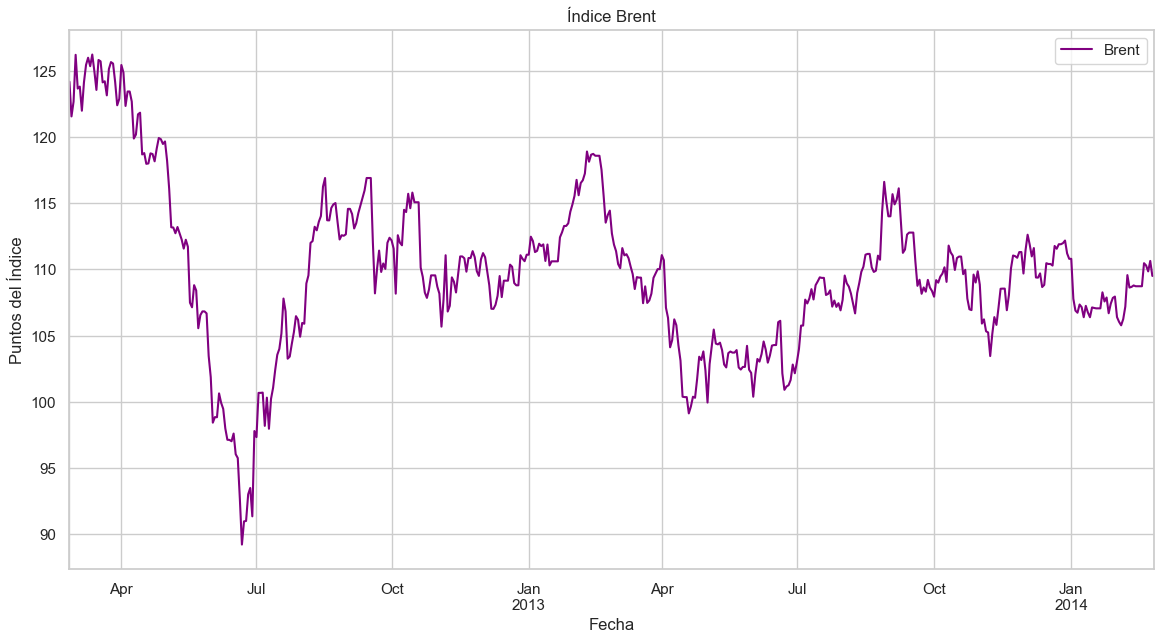

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['brent'].plot(label='Brent', color='purple')

# Añadir títulos
plt.title('Índice Brent')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Índice Oro

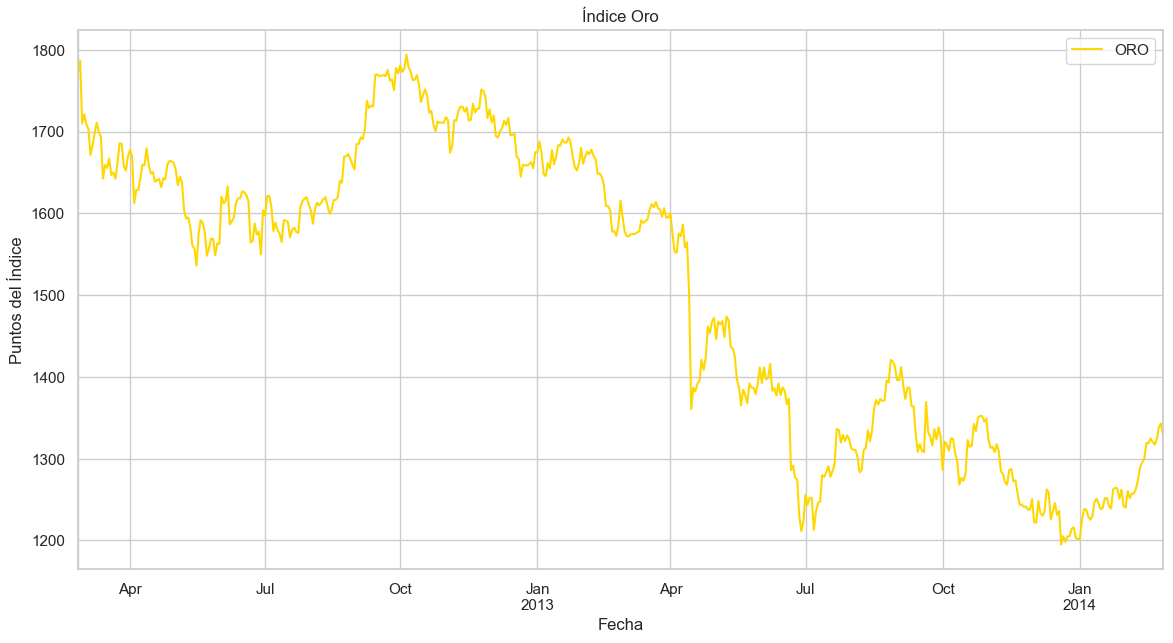

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['gold'].plot(label='ORO', color='gold')

# Añadir títulos
plt.title('Índice Oro')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Índice DAX

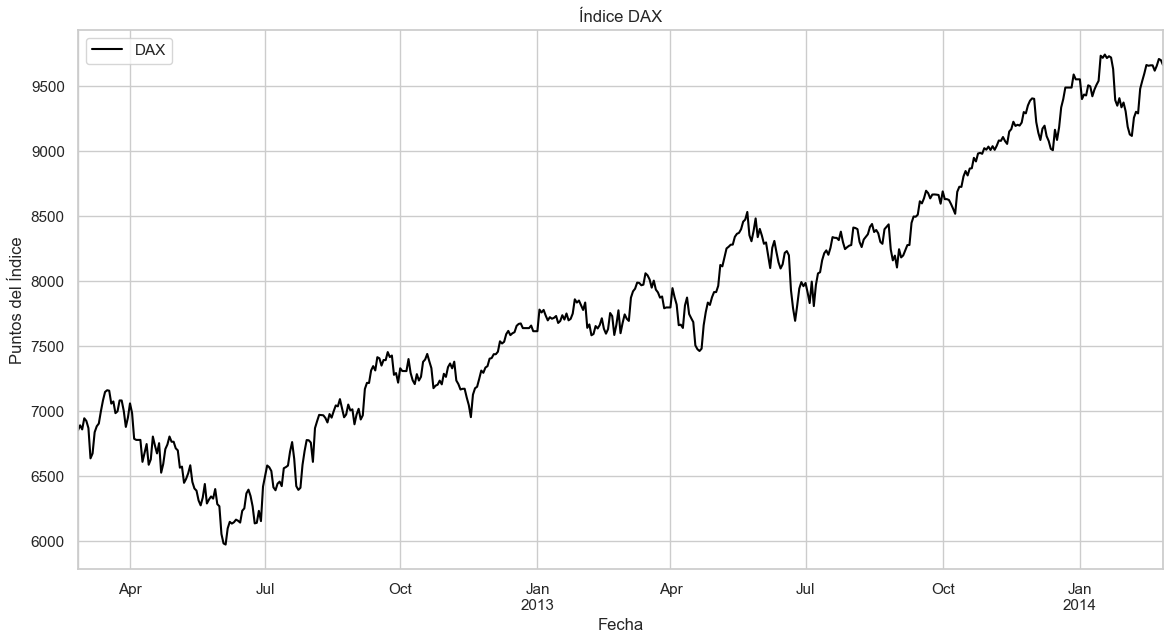

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['dax'].plot(label='DAX', color='black')

# Añadir títulos
plt.title('Índice DAX')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Índice Stoxx

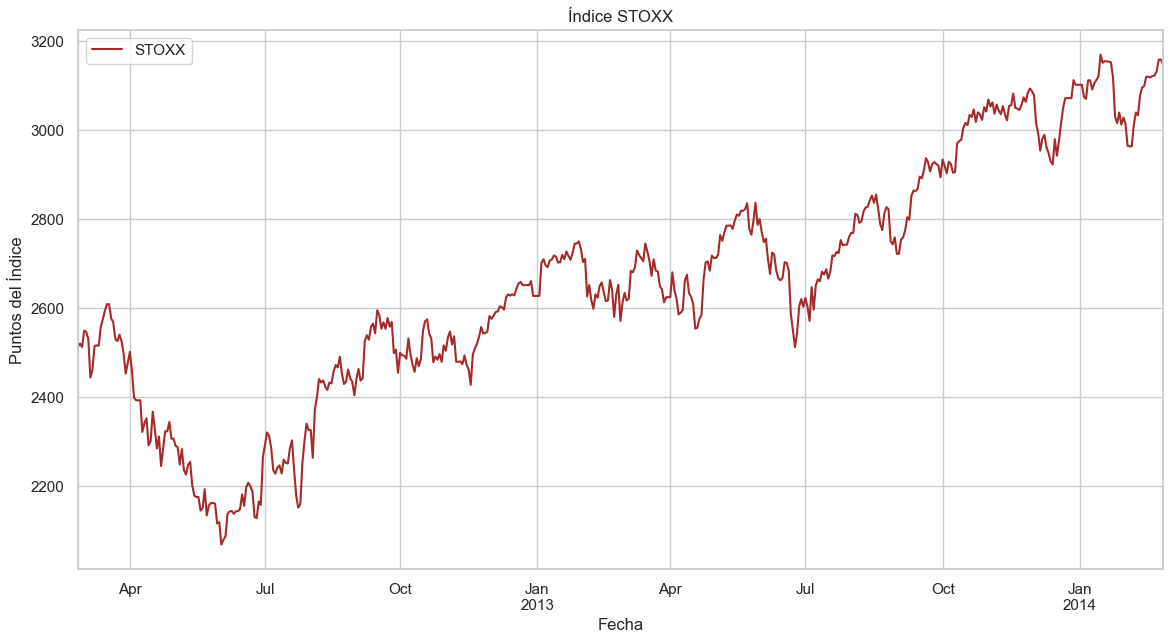

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['stoxx'].plot(label='STOXX', color='brown')

# Añadir títulos
plt.title('Índice STOXX')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Índice MOEX

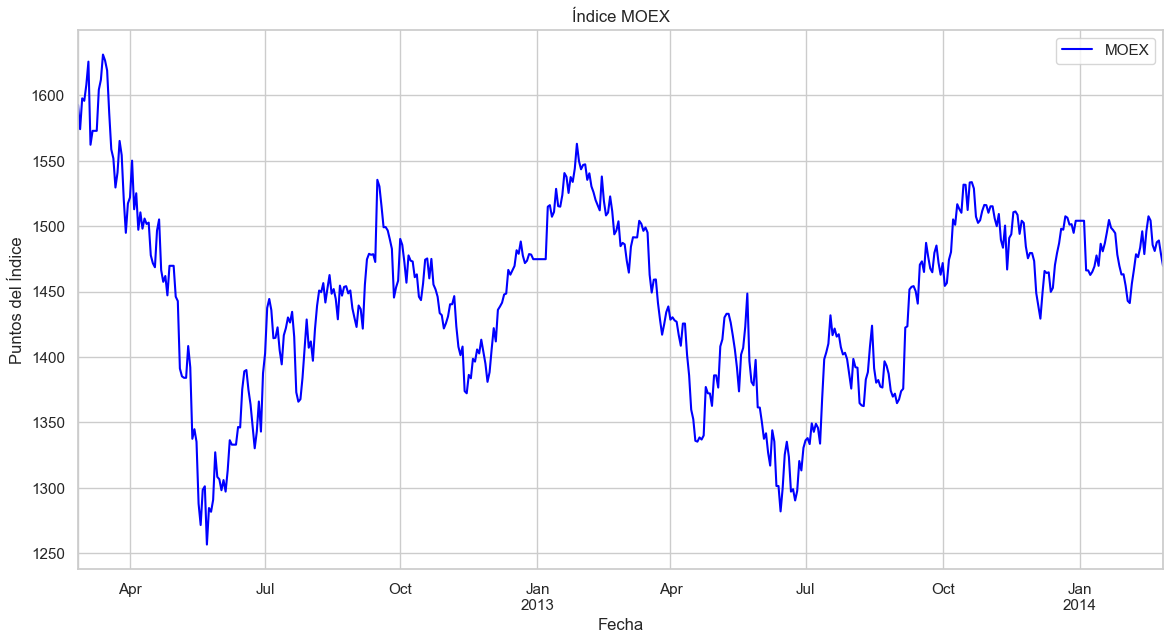

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un estilo
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar los datos
master_df['moex'].plot(label='MOEX', color='blue')

# Añadir títulos
plt.title('Índice MOEX')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Puntos del Índice', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()